In [140]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pybamm
import pickle
import os
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [141]:
# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

In [142]:
# Here I am not going to work with changing the initial conditions the gradient descent
# so this is taking the ICs for granted 
Ms = 32
n4 = 4
F = 9.649e4
S8_initial = 2.6730
ns8 = 8
S4_initial = 0.0128
ns4 = 4
cth = ((3 * n4 * F * S8_initial / (ns8 * Ms)) + (n4 * F * S4_initial / (ns4 * Ms))) / 3600

# define the initial values in grams of various species
S8_initial_g = 2.6730
S4_initial_g = 0.0128
S2_initial_g = 4.3321e-6
S1_initial_g = 1.6321e-6
Sp_initial_g = 2.7e-06

# the total active material mass
m_s = S8_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.3

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [143]:
def discharge_function(inputs):
    
    fitted_params_dict, discharge_initial_data, temp = inputs
    
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.MarinescuEtAl2016_ks_temp()
    
    # non-fitted parameters
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = discharge_initial_data
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Ambient Temperature [K]": temp
        }
    )
    # fitted parameters
    params.update(fitted_params_dict)
    
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying number of time steps %f" %10**j)
        print("parameters are {}".format(fitted_params_dict))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = [t, Ah, V, S8, S4, S2, S1, Sp, Tc]
            return data
            
            break
        except:
            pass

In [144]:
def charge_function(inputs):
    
    fitted_params_dict, charge_initial_data, temp = inputs
    
    current = -0.0211 # .1C charge
    model = pybamm.lithium_sulfur.MarinescuEtAl2016_ks_temp()
    
    # non-fitted parameters
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = charge_initial_data
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Ambient Temperature [K]": temp
        }
    )
    # fitted parameters
    params.update(fitted_params_dict)
    
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying number of time steps %f" %10**j)
        print("parameters are {}".format(fitted_params_dict))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = [t, Ah, V, S8, S4, S2, S1, Sp, Tc]
            return data
            
            break
        except:
            pass

In [92]:
# Test that we get 'correct' behavior on discharge
discharge_sim_data = {}
for temp_c in [20,30,40]:
    # set up inputs
    fitted_params_dict = {}
    temp_k = temp_c + 272
    inputs = fitted_params_dict, discharge_initial_data, temp_k
    
    # simulate
    sim_data = discharge_function(inputs)
    
    # record data
    discharge_sim_data[str(temp_c)] = sim_data
    


Starting temperature 292.000000
trying number of time steps 1000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 312.000000
trying number of time steps 1000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

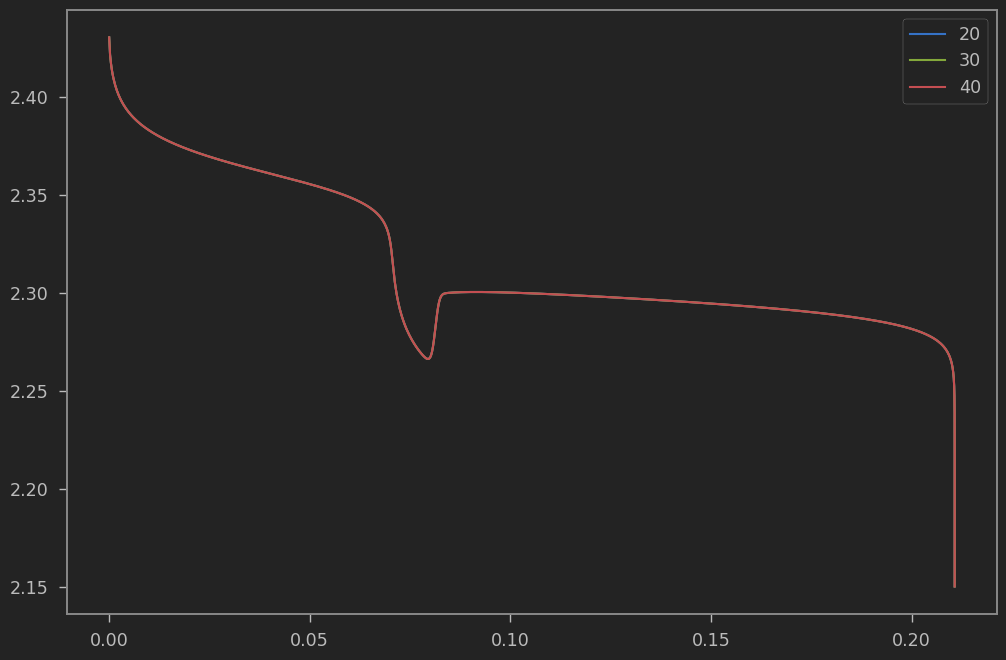

In [94]:
for data in discharge_sim_data.values():
    plt.plot(data[1],data[2])
plt.legend(discharge_data.keys())

In [31]:
# Test that we get 'correct' behavior on charge

# get IC
charge_initial_data = []
for sub_data in discharge_data['30'][2:-1]:
    charge_initial_data.append(sub_data[-100])
    
charge_data = {}
for temp_c in [20,30,40]:
    # set up inputs
    fitted_params_dict = {}
    temp_k = temp_c + 272
    inputs = fitted_params_dict, charge_initial_data, temp_k
    
    # simulate
    sim_data = charge_function(inputs)
    
    # record data
    charge_data[str(temp_c)] = sim_data


Starting temperature 292.000000
trying number of time steps 1000.000000
parameters are {}
Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {}
Starting temperature 312.000000
trying number of time steps 1000.000000
parameters are {}


Text(0.5, 1.0, 'Marinscu et al (2016) with modified ks(Tc) charge')

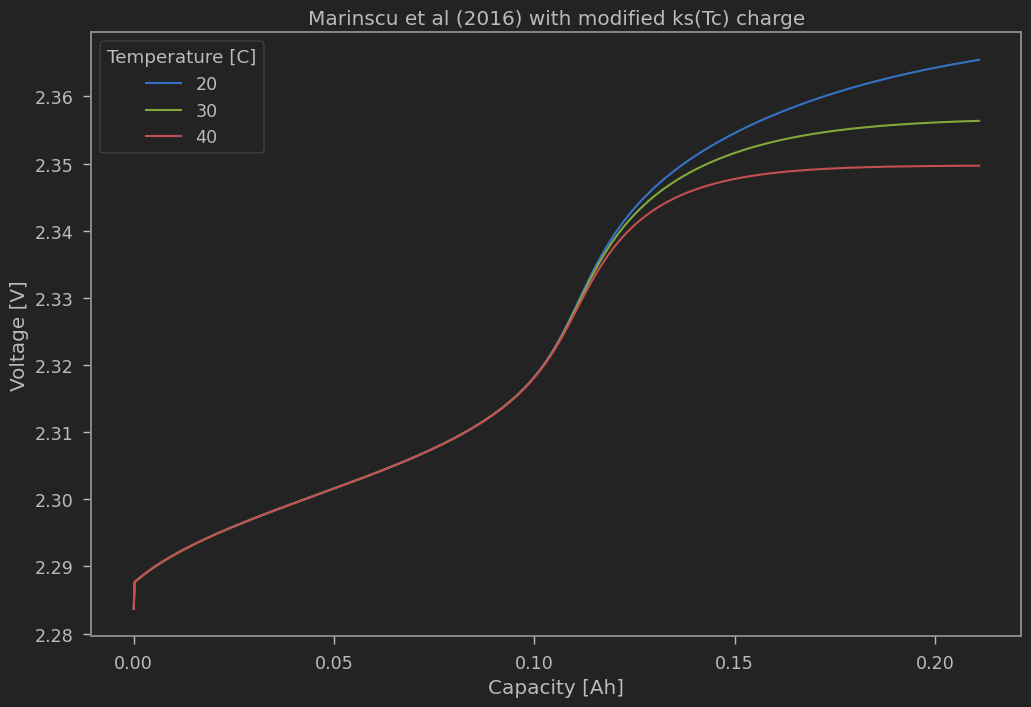

In [37]:
for data in charge_data.values():
    plt.plot(data[1],data[2])
plt.legend(charge_data.keys(), title  = 'Temperature [C]')
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Marinscu et al (2016) with modified ks(Tc) charge')

In [33]:
for temp in [292.15, 302.15,312.15]:
    k_s = (2e-4)*np.exp( (8.9712*6.0221*1e3)*( (1/temp) - (1/298) )/8.3145  )
    coef = (9.649e4)/(1.68*1.28*10)
    print(coef*k_s)

1.3887095143612707
0.6651650304943212
0.33398733306769784


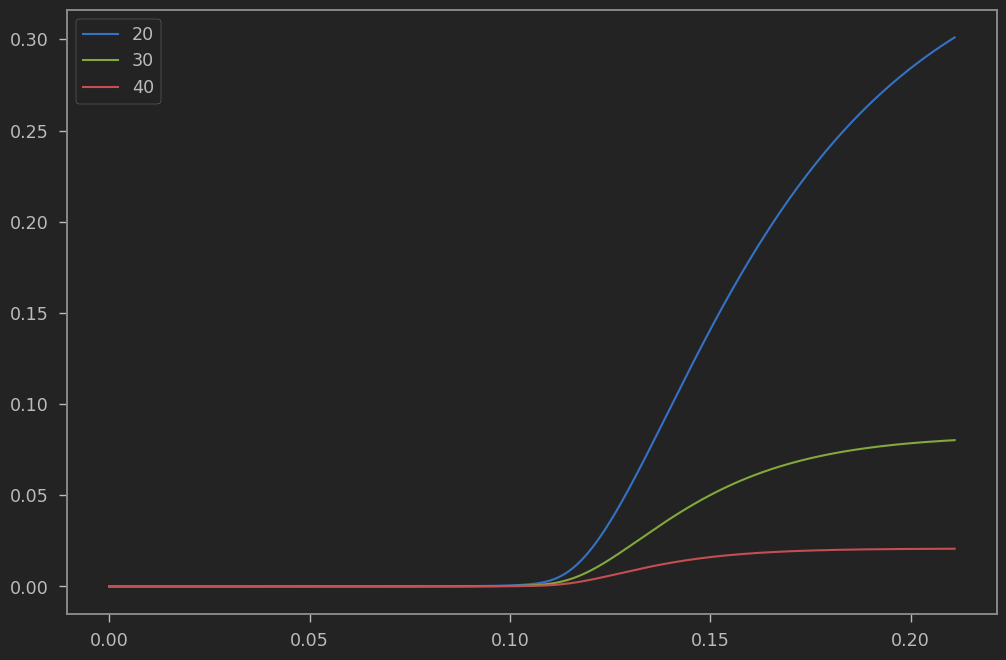

In [35]:
for data in charge_data.values():
    temp = data[-1]
    V = data[2]
    S8 = data[3]
    Ah = data[1]
    k_s = (2e-4)*np.exp( (8.9712*6.0221*1e3)*( (1/temp) - (1/298) )/8.3145  )
    coef = (9.649e4)/(1.68*1.28*10)
    
    plt.plot(Ah, coef*k_s*S8*V)
plt.legend(charge_data.keys())

In [145]:
# initial cycling

fitted_params_dict = {}
temp = 30 + 272
inputs = fitted_params_dict, discharge_initial_data, temp

# Discharge 1
discharge1_sim_data = discharge_function(inputs)

# Get IC for Charge 1
charge1_initial_data = []
for sub_data in discharge1_sim_data[2:-1]:
    charge1_initial_data.append(sub_data[-2])
    
# Charge 1
inputs = fitted_params_dict, charge1_initial_data, temp
charge1_sim_data = charge_function(inputs)

# Get IC for Discharge 2
discharge2_initial_data = []
for sub_data in charge1_sim_data[2:-1]:
    discharge2_initial_data.append(sub_data[-2])
    
# Discharge 2
inputs = fitted_params_dict, discharge2_initial_data, temp
discharge2_sim_data = discharge_function(inputs)

# Get IC for Charge 2
charge2_initial_data = []
for sub_data in discharge2_sim_data[2:-1]:
    charge2_initial_data.append(sub_data[-2])
    
# Charge 2
inputs = fitted_params_dict, charge2_initial_data, temp
charge2_sim_data = charge_function(inputs)

# Get IC for Discharge 3
discharge3_initial_data = []
for sub_data in charge2_sim_data[2:-1]:
    discharge3_initial_data.append(sub_data[-2])
    
# Discharge 3
inputs = fitted_params_dict, discharge3_initial_data, temp
discharge3_sim_data = discharge_function(inputs)

# Get IC for fitting Charge
charge3_initial_data = []
for sub_data in discharge3_sim_data[2:-1]:
    charge3_initial_data.append(sub_data[-2])
    
# create initial base simulation for parameter fitting
inputs = fitted_params_dict, charge3_initial_data, temp
base_sim = charge_function(inputs)

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {}
trying number of time steps 10000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 13746.2 and h

trying number of time steps 100000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {}
trying number of time steps 10000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 13746.2 and h

trying number of time steps 100000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {}
trying number of time steps 10000.000000
parameters are {}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [44]:
# Here we will perform the charge fitting
def quick_norm(gradient):
    values = np.array(list(gradient.values()))
    return sum(values*values)

def gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage):
    fitted_params_dict, charge_initial_data, temp = inputs
    # create steps for each parameter to fit
    individually_stepped_params = []
    
    epsilon = 0.0001
    for key in fitted_params_dict.keys():
        individually_stepped_params_dict = fitted_params_dict
        individually_stepped_params_dict[key] = fitted_params_dict[key]*(1+epsilon)
        individually_stepped_params.append(individually_stepped_params_dict)
    print('\n\n\n')
    print(individually_stepped_params)
    print('\n\n\n')
    
    # run new simulations with individually stepped parameters
    individually_stepped_inputs = []
    for param_dict in individually_stepped_params:
        individually_stepped_inputs.append([param_dict,charge_initial_data, temp])
    
    individually_stepped_sims = Parallel(n_jobs=-1)(delayed(charge_function)(inputs) for inputs in individually_stepped_inputs)

    # downsample each sim to be able to subtract from base_sim for numerical derivative
    gradient = {}
    for i in range(0,len(individually_stepped_sims)):
        
        key = list(fitted_params_dict.keys())[i]
        sim = individually_stepped_sims[i]
        # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes

        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sim[1], sim[2])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon 
        gradient[key] = sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage)
        print(gradient)
    
    # perform parameter update
    lam = 0.00001
    print(quick_norm(gradient))
    updated_params_dict = {}
    for key in fitted_params_dict:
        updated_params_dict[key] = fitted_params_dict[key] - lam*(gradient[key] +  np.random.rand(1)[0])
    print(updated_params_dict)
    return updated_params_dict, gradient
    
    

def down_sampled_sim_voltage_func(Ah, V, exp_capacity, exp_voltage):

    # check if simulation stops short of experimental capacity and adjust
    if Ah[-1] < exp_capacity[-1]:
        exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]

    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)
    
    return down_sampled_sim_voltage

def gradient_descent_proceedure(simulations_at_each_step, parameters_at_each_step,charge_initial_condition, temp):
    # get experimental data
    exp_capacity = charge_data['30']['capacity']
    exp_voltage = charge_data['30']['internal voltage'][0:len(exp_capacity)]
    
    # get new parameters
    params = parameters_at_each_step[-1]
    
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp, Tc = simulations_at_each_step[-1]
    
    # get down-sampled sim voltage
    down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)
    
    condition = True
    while condition:
        inputs = parameters_at_each_step[-1], charge_initial_condition, temp
        
        # perform gradient descent step from latest simulation & parameters
        print('\n\n Performing Gradient Descent Step \n\n')
        try:
            updated_params, gradient = gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage)

            # update parameter data
            parameters_at_each_step.append(updated_params)

            # perform simulation with new parameters
            inputs = parameters_at_each_step[-1], charge_initial_condition, temp
            print('\n\n Performing New Simulation \n\n')
            new_base_sim = charge_function(inputs)

            # down-sample sim data to experimental data
            t, Ah, V, S8, S4, S2, S1, Sp, Tc = new_base_sim
            down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)

            # update simulation data set
            simulations_at_each_step.append(new_base_sim)
        except:
            condition = False
        #if quick_norm(gradient)<1e-3:
        #    condition = False
        if len(simulations_at_each_step) > 20:
            condition = False
            
    return simulations_at_each_step, parameters_at_each_step

In [8]:
simulations_at_each_step = [base_sim]
parameters_at_each_step = [{'Active reaction area per cell [m2]': 0.96}]
simulations_at_each_step, parameters_at_each_step = gradient_descent_proceedure(simulations_at_each_step, parameters_at_each_step,charge3_initial_data, temp)



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.960096}]




{'Active reaction area per cell [m2]': -3.358349893649466e-06}
1.127851400817538e-11
{'Active reaction area per cell [m2]': 0.9598730023277374}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9598730023277374}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9598730023277374}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9599689896279702}]




{'Active reaction area per cell [m2]': -3.4011046177672103e-06}
1.1567512620997442e-11
{'Active reaction area per cell [m2]': 0.9596327724832148}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9596327724832148}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9596327724832148}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.959728735760463}]




{'Active reaction area per cell [m2]': -3.349248766643744e-06}
1.1217467300864639e-11
{'Active reaction area per cell [m2]': 0.959246565696944}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.959246565696944}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.959246565696944}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9593424903535137}]




{'Active reaction area per cell [m2]': -3.3708057743542694e-06}
1.1362331568420086e-11
{'Active reaction area per cell [m2]': 0.9586300644050977}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9586300644050977}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9586300644050977}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9587259274115382}]




{'Active reaction area per cell [m2]': -3.2044645720315962e-06}
1.0268593193405641e-11
{'Active reaction area per cell [m2]': 0.95783331582663}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.95783331582663}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.95783331582663}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9579290991582127}]




{'Active reaction area per cell [m2]': -3.232522044950501e-06}
1.0449198771090968e-11
{'Active reaction area per cell [m2]': 0.9572595941040831}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9572595941040831}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9572595941040831}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9573553200634936}]




{'Active reaction area per cell [m2]': -3.315646486707653e-06}
1.0993511624816803e-11
{'Active reaction area per cell [m2]': 0.9571080019525776}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9571080019525776}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9571080019525776}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9572037127527728}]




{'Active reaction area per cell [m2]': -3.3380216772121837e-06}
1.114238871753844e-11
{'Active reaction area per cell [m2]': 0.9565022958893157}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9565022958893157}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9565022958893157}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9565979461189046}]




{'Active reaction area per cell [m2]': -3.227689186382299e-06}
1.0417977483889228e-11
{'Active reaction area per cell [m2]': 0.9564025695945203}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9564025695945203}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9564025695945203}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9564982098514797}]




{'Active reaction area per cell [m2]': -3.363492204215633e-06}
1.1313079807819338e-11
{'Active reaction area per cell [m2]': 0.9558329189588519}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9558329189588519}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9558329189588519}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9559285022507478}]




{'Active reaction area per cell [m2]': -3.1932063445956652e-06}
1.019656675916601e-11
{'Active reaction area per cell [m2]': 0.955263563201202}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.955263563201202}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.955263563201202}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9553590895575221}]




{'Active reaction area per cell [m2]': -3.363519083350013e-06}
1.1313260624059712e-11
{'Active reaction area per cell [m2]': 0.9553532345510544}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9553532345510544}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9553532345510544}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9554487698745094}]




{'Active reaction area per cell [m2]': -3.302122129705812e-06}
1.0904010559492848e-11
{'Active reaction area per cell [m2]': 0.9553572598634293}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9553572598634293}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9553572598634293}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9554527955894156}]




{'Active reaction area per cell [m2]': -3.352565992452551e-06}
1.1239698733749357e-11
{'Active reaction area per cell [m2]': 0.9545735603464685}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9545735603464685}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9545735603464685}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9546690177025031}]




{'Active reaction area per cell [m2]': -3.3436116366026008e-06}
1.1179738776424322e-11
{'Active reaction area per cell [m2]': 0.9546557257347706}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9546557257347706}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9546557257347706}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9547511913073441}]




{'Active reaction area per cell [m2]': -3.3069131382249864e-06}
1.0935674503765028e-11
{'Active reaction area per cell [m2]': 0.9537704433786478}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9537704433786478}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9537704433786478}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9538658204229856}]




{'Active reaction area per cell [m2]': -3.3804340726956552e-06}
1.1427334519841734e-11
{'Active reaction area per cell [m2]': 0.9536096002998194}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9536096002998194}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9536096002998194}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9537049612598494}]




{'Active reaction area per cell [m2]': -3.3862866261422245e-06}
1.146693711438969e-11
{'Active reaction area per cell [m2]': 0.9530565625078021}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9530565625078021}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9530565625078021}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.953151868164053}]




{'Active reaction area per cell [m2]': -3.3376686884924113e-06}
1.1140032274142653e-11
{'Active reaction area per cell [m2]': 0.9527646075860838}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9527646075860838}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9527646075860838}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c



 Performing Gradient Descent Step 






[{'Active reaction area per cell [m2]': 0.9528598840468424}]




{'Active reaction area per cell [m2]': -3.255335513794513e-06}
1.0597209307371786e-11
{'Active reaction area per cell [m2]': 0.9519385401723504}


 Performing New Simulation 


Starting temperature 302.000000
trying number of time steps 1000.000000
parameters are {'Active reaction area per cell [m2]': 0.9519385401723504}
trying number of time steps 10000.000000
parameters are {'Active reaction area per cell [m2]': 0.9519385401723504}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

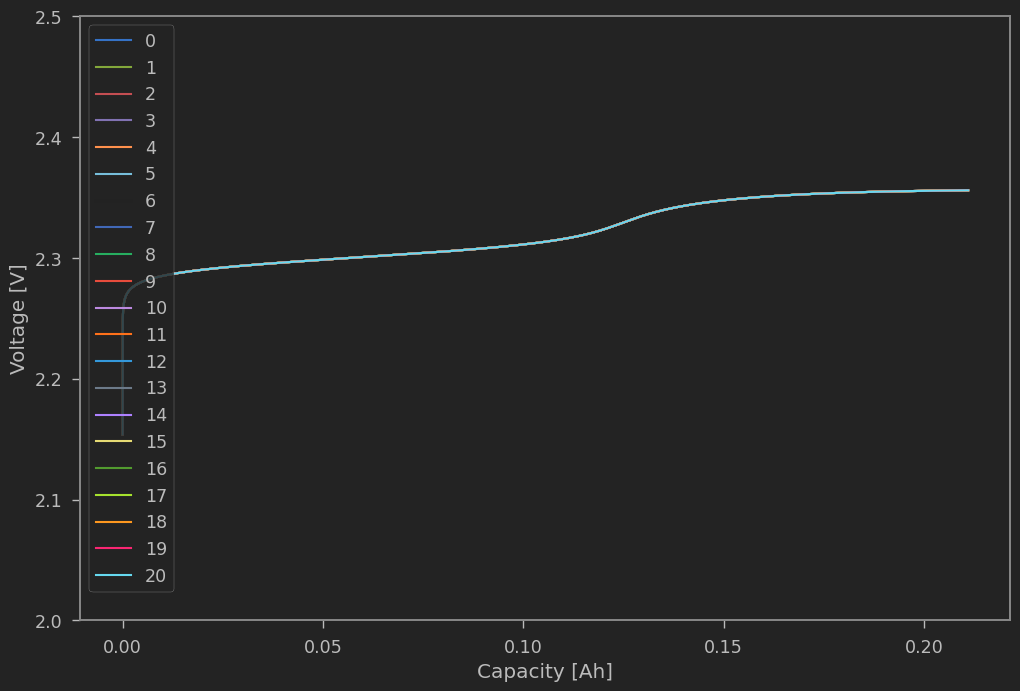

In [9]:
for simulations in simulations_at_each_step:
    plt.plot(simulations[1],simulations[2])
#plt.plot(simulations_at_each_step[-2][1],simulations_at_each_step[-2][2],color='red')
plt.legend(np.arange(len(simulations_at_each_step)))
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.ylim(2,2.5)
notify

In [45]:
parameters_at_each_step = [{"Initial Condition for S8 ion [g]": S8_initial_hunt ,
        "Initial Condition for S4 ion [g]": S4_initial_hunt ,
        "Initial Condition for S2 ion [g]": S2_initial_hunt ,
        "Initial Condition for S ion [g]": S1_initial_hunt }
                          ]

simulations_at_each_step = [base_sim]
temp = 30
simulations_at_each_step, parameters_at_each_step = gradient_descent_proceedure(simulations_at_each_step, parameters_at_each_step,charge3_initial_data, temp)



 Performing Gradient Descent Step 






[{'Initial Condition for S8 ion [g]': 0.16721552521082975, 'Initial Condition for S4 ion [g]': 0.0008007327806579202, 'Initial Condition for S2 ion [g]': 2.710042561787637e-07, 'Initial Condition for S ion [g]': 1.0209968525873371e-07}, {'Initial Condition for S8 ion [g]': 0.16721552521082975, 'Initial Condition for S4 ion [g]': 0.0008007327806579202, 'Initial Condition for S2 ion [g]': 2.710042561787637e-07, 'Initial Condition for S ion [g]': 1.0209968525873371e-07}, {'Initial Condition for S8 ion [g]': 0.16721552521082975, 'Initial Condition for S4 ion [g]': 0.0008007327806579202, 'Initial Condition for S2 ion [g]': 2.710042561787637e-07, 'Initial Condition for S ion [g]': 1.0209968525873371e-07}, {'Initial Condition for S8 ion [g]': 0.16721552521082975, 'Initial Condition for S4 ion [g]': 0.0008007327806579202, 'Initial Condition for S2 ion [g]': 2.710042561787637e-07, 'Initial Condition for S ion [g]': 1.0209968525873371e-07}]




{'Initia

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 100000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.16473812133499585, 'Initial Condition for S4 ion [g]': -0.0016712564957685296, 'Initial Condition for S2 ion [g]': -0.0024691881516396203, 'Initial Condition for S ion [g]': -0.002476646242600814}
trying number of time steps 1000000.000000
parameters are {'Initial Condition for S8 ion [g]': 0.16473812133499585, 'Initial Condition for S4 ion [g]': -0.0016712564957685296, 'Initial Condition for S2 ion [g]': -0.0024691881516396203, 'Initial Condition for S ion [g]': -0.002476646242600814}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

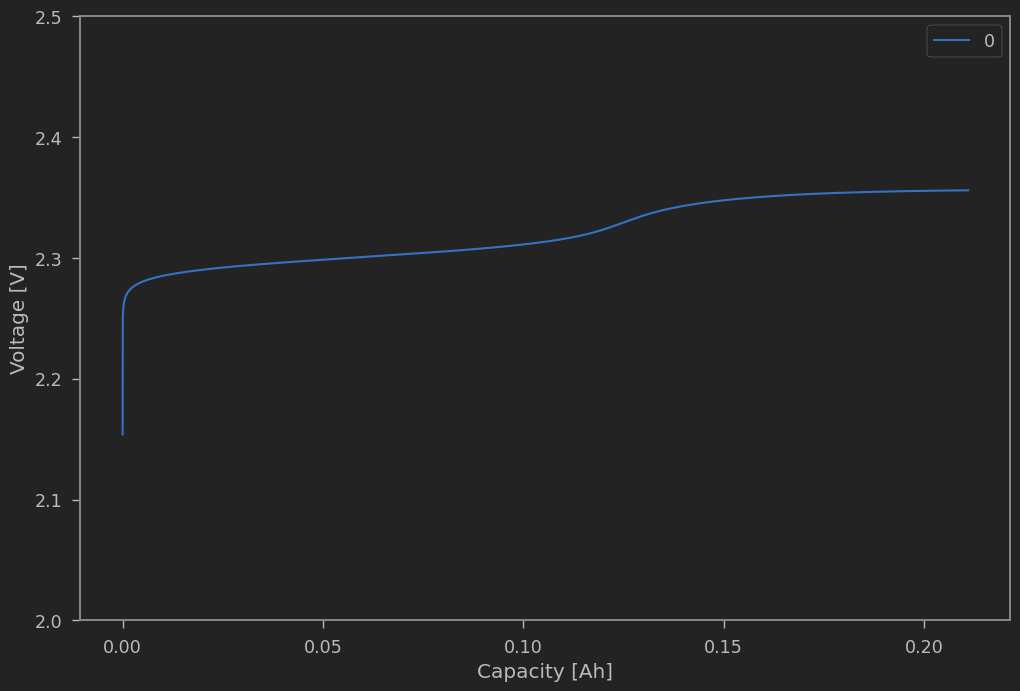

In [46]:
for simulations in simulations_at_each_step:
    plt.plot(simulations[1],simulations[2])
#plt.plot(simulations_at_each_step[-2][1],simulations_at_each_step[-2][2],color='red')
plt.legend(np.arange(len(simulations_at_each_step)))
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.ylim(2,2.5)
notify

In [160]:
# changing the functions to allow for the cost function
# which holds information for mass conservation and
# strict positivity


# Here we will perform the charge fitting
def quick_norm(gradient):
    values = np.array(list(gradient.values()))
    return sum(values*values)

def gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage):
    fitted_params_dict, discharge_initial_data, temp = inputs
    # create steps for each parameter to fit
    individually_stepped_params = []
    
    epsilon = 0.1
    for key in fitted_params_dict.keys():
        individually_stepped_params_dict = fitted_params_dict
        #print('Initial Dictionary')
        #print(individually_stepped_params_dict)
        individually_stepped_params_dict[key] = fitted_params_dict[key]*(1+epsilon)
        #print('Updated Dictionary')
        #print(individually_stepped_params_dict)
        individually_stepped_params.append(individually_stepped_params_dict)
    #print('\n\n\n')
    #print(individually_stepped_params)
    #print('\n\n\n')
    
    # run new simulations with individually stepped parameters
    individually_stepped_inputs = []
    for param_dict in individually_stepped_params:
        individually_stepped_inputs.append([param_dict,discharge_initial_data, temp])
    
    print('\n\n\n')
    print('Performing Parallel Simulations')
    print('\n\n\n')
    individually_stepped_sims = Parallel(n_jobs=-1)(delayed(discharge_function)(inputs) for inputs in individually_stepped_inputs)
    print('\n\n\n')
    print('Finished Performing Parallel Simulations')
    print('\n\n\n')
    # downsample each sim to be able to subtract from base_sim for numerical derivative
    gradient = {}
    for i in range(0,len(individually_stepped_sims)):
        
        key = list(fitted_params_dict.keys())[i]
        sim = individually_stepped_sims[i]
        # at this point we're hoping there isn't a substantial difference in capacity due to parameter changes

        # down sample simulated voltage for comparison with experimental 
        temp_sim_V = np.interp(exp_capacity, sim[1], sim[2])
        voltage_partial_deriv_data =  (temp_sim_V-down_sampled_sim_voltage)/epsilon 
        voltage_cost = sum( (down_sampled_sim_voltage - exp_voltage)*voltage_partial_deriv_data )*2/len(exp_voltage)
        mass_conservation_cost = 2*(sim[3][0]+sim[4][0]+sim[5][0]+sim[6][0]+sim[7][0] - .168)
        non_zero_cost = -(1e-6)/(sim[i+3][0])
        gradient[key] = voltage_cost+mass_conservation_cost+non_zero_cost
        print(key)
        print('Voltage Cost = ' + str(voltage_cost))
        print('Mass Conservation Cost = ' + str(mass_conservation_cost))
        print('Zero Species Value Cost = '+ str(non_zero_cost))
        print('\n \n')
    print('The gradient is:')
    print(gradient)
    
    # perform parameter update
    lam = 1e-6
    print('Gradient norm = ' + str(quick_norm(gradient)))
    updated_params_dict = {}
    for key in fitted_params_dict:
        updated_params_dict[key] = fitted_params_dict[key] - lam*(gradient[key] +  np.random.rand(1)[0])
    print('The updated parameters are:')
    print(updated_params_dict)
    return updated_params_dict, gradient
    
    

def down_sampled_sim_voltage_func(Ah, V, exp_capacity, exp_voltage):

    # check if simulation stops short of experimental capacity and adjust
    if Ah[-1] < exp_capacity[-1]:
        exp_capacity = exp_capacity[exp_capacity <= Ah[-1]]

    # down sample simulated voltage for comparison with experimental 
    down_sampled_sim_voltage = np.interp(exp_capacity, Ah, V)
    
    return down_sampled_sim_voltage

def gradient_descent_proceedure(simulations_at_each_step, parameters_at_each_step,discharge_initial_condition, temp):
    # get experimental data
    exp_capacity = discharge_data['30']['capacity']
    exp_voltage = discharge_data['30']['internal voltage'][0:len(exp_capacity)]
    
    # get new parameters
    params = parameters_at_each_step[-1]
    
    # get simulation data
    t, Ah, V, S8, S4, S2, S1, Sp, Tc = simulations_at_each_step[-1]
    
    # get down-sampled sim voltage
    down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)
    
    condition = True
    while condition:
        inputs = parameters_at_each_step[-1], discharge_initial_condition, temp
        
        # perform gradient descent step from latest simulation & parameters
        print('\n\n Performing Gradient Descent Step \n\n')
        try:
            updated_params, gradient = gradient_descent_step(inputs,exp_capacity,exp_voltage,down_sampled_sim_voltage)

            # update parameter data
            parameters_at_each_step.append(updated_params)

            # perform simulation with new parameters
            inputs = parameters_at_each_step[-1], discharge_initial_condition, temp
            print('\n\n Performing New Simulation \n\n')
            new_base_sim = discharge_function(inputs)

            # down-sample sim data to experimental data
            t, Ah, V, S8, S4, S2, S1, Sp, Tc = new_base_sim
            down_sampled_sim_voltage = down_sampled_sim_voltage_func(Ah, V,exp_capacity, exp_voltage)

            # update simulation data set
            simulations_at_each_step.append(new_base_sim)
        except:
            condition = False
        #if quick_norm(gradient)<1e-3:
        #    condition = False
        if len(simulations_at_each_step) > 20:
            condition = False
            
    return simulations_at_each_step, parameters_at_each_step

In [161]:
parameters_at_each_step = [
    {
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5]
    }                      
]

simulations_at_each_step = [discharge3_sim_data]
temp = 30
simulations_at_each_step, parameters_at_each_step = gradient_descent_proceedure(simulations_at_each_step, parameters_at_each_step, discharge_initial_data, temp)



 Performing Gradient Descent Step 






Performing Parallel Simulations








Finished Performing Parallel Simulations






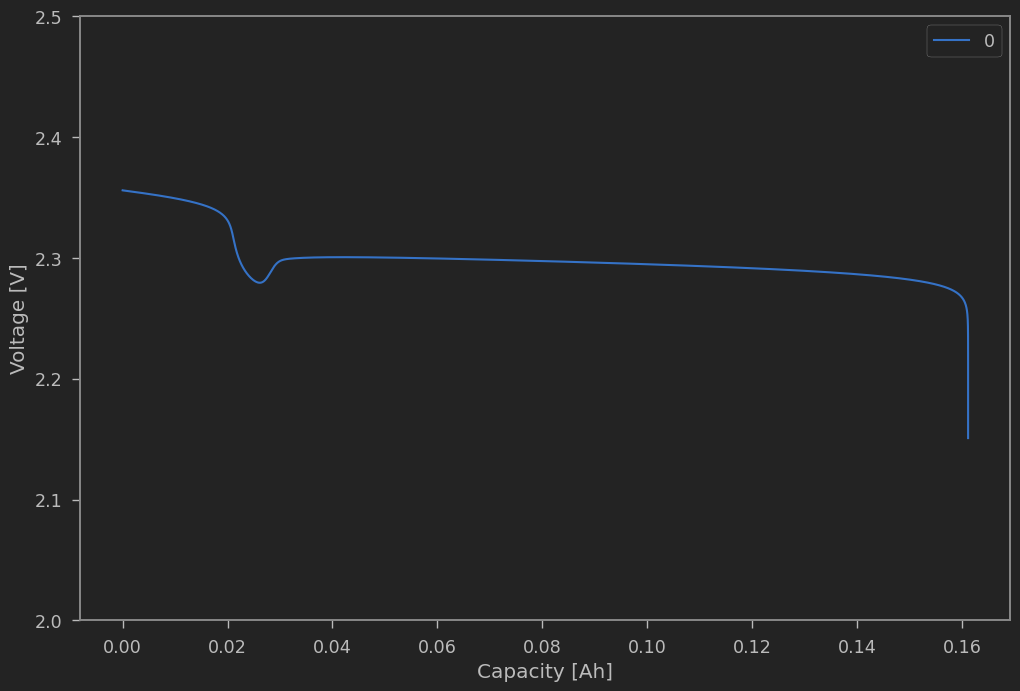

In [159]:
for simulations in simulations_at_each_step:
    plt.plot(simulations[1],simulations[2])
#plt.plot(simulations_at_each_step[-2][1],simulations_at_each_step[-2][2],color='red')
plt.legend(np.arange(len(simulations_at_each_step)))
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.ylim(2,2.5)
notify

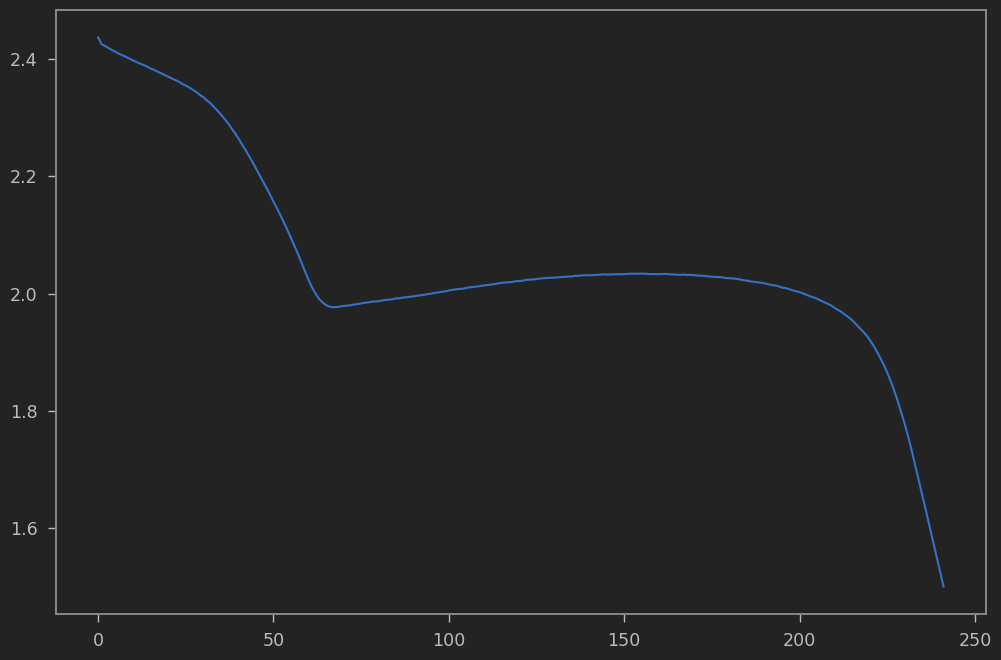

In [139]:
plt.plot(discharge_data['30']['terminal voltage'])

In [149]:
discharge3_initial_data

[2.35603273609921,
 0.049223874931121896,
 0.11859166106456033,
 9.223200215432484e-05,
 3.306409318223723e-05,
 5.9167908978417395e-05]